In [34]:
import os
import pandas as pd
import argparse
import warnings
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from utils import *
from torch import nn
import copy
from tqdm import tqdm
import random 
import numpy as np
from scipy import stats
from train import train_parameter, test_parameter, train_non_parameter, test_non_parameter
from model_non_parameter import ANN_gaussian, ANN_quantile,DRO_layer_dynamic_price,Intra_schdule_layer,Determinisitic_layer
from model_non_parameter import Combined_model_non_parameter_dynamic_price,Combined_deterministic_non_parameter_dynamic_price
from optimization import SO_cvxpy_parameter,DRO_cvxpy_non_parameter
from test_non_parameter import Evaluation_deterministic_non_parameter,Evaluation_original_model_non_parameter
from online_non_parameter import *
warnings.filterwarnings("ignore")
#torch.set_default_dtype(torch.float64)

In [35]:
set_seed(42)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [36]:
parser_train = argparse.ArgumentParser()
parser_train.add_argument('--seq_len', type=int, default=24*7)
parser_train.add_argument('--pred_len', type=int, default=24)
parser_train.add_argument('--label_len', type=int, default=0)
parser_train.add_argument('--train_length', type=int, default=17376)
parser_train.add_argument('--target', type=str, default='target')
parser_train.add_argument('--scale', type=bool, default=True)
parser_train.add_argument('--inverse', type=bool, default=True)
parser_train.add_argument('--num_epochs', type=int, default=1000)
parser_train.add_argument('--mode', type=str, default='no-parameter')
parser_train.add_argument('--quantiles', type=list, default=[0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95])
parser_train.add_argument('--lr', type=float, default=5e-3)
parser_train.add_argument('--patience', type=int, default=20)
parser_train.add_argument('--hidden_layers', type=list, default=[128,128,128])
parser_train.add_argument('--e2e_num_epochs', type=int, default=5)
parser_train.add_argument('--e2e_lr', type=float, default=1e-6)
parser_train.add_argument('--e2e_ft_lr', type=float, default=1e-6)
parser_train.add_argument('--ft_lr', type=int, default=1e-3)
parser_train.add_argument('--batch_size', type=int, default=16)
parser_train.add_argument('--device', type=str, default='cuda:0' if torch.cuda.is_available() else 'cpu')
parser_train.add_argument('--epsion_p', type=float, default=1e1)
parser_train.add_argument('--epsion_l', type=float, default=1e1)
parser_train.add_argument('--metric_list', type=list, default=['pinball_loss','winkler_score_0.1','MAE','RMSE'])

parser_train.add_argument('--T', type=int, default=24)
parser_train.add_argument('--N', type=int, default=25)
parser_train.add_argument('--N_g', type=int, default=3)
parser_train.add_argument('--x_max', type=int, default=3000)
parser_train.add_argument('--x_min', type=int, default=0)
parser_train.add_argument('--z_pos_max', type=list, default=[500,700,800])
parser_train.add_argument('--z_neg_max', type=list, default=[500,700,800])
parser_train.add_argument('--z_pos_min', type=int, default=0)
parser_train.add_argument('--z_neg_min', type=int, default=0)
parser_train.add_argument('--r_neg', type=int, default=1000)
parser_train.add_argument('--r_pos', type=int, default=1000)
parser_train.add_argument('--alpha', type=list, default=[0.03 for i in range(24)]+[0.028 for i in range(24)]+[0.032 for i in range(24)])
parser_train.add_argument('--alpha_pos', type=list, default=[0.02 for i in range(24)]+[0.018 for i in range(24)]+[0.022 for i in range(24)])
parser_train.add_argument('--alpha_neg', type=list, default=[0.01 for i in range(24)]+[0.009 for i in range(24)]+[0.011 for i in range(24)])

parser_train.add_argument('--rho_z_pos', type=list, default=[0.05 for i in range(24)]+[0.045 for i in range(24)]+[0.055 for i in range(24)])
parser_train.add_argument('--rho_z_neg', type=list, default=[0.01 for i in range(24)]+[0.008 for i in range(24)]+[0.012 for i in range(24)])

parser_train.add_argument('--rho_r_pos', type=list, default=[0.1 for i in range(24)])
parser_train.add_argument('--rho_r_neg', type=list, default=[0.05 for i in range(24)])

parser_train.add_argument('--price_ratio_large', type=float, default=4)
parser_train.add_argument('--price_ratio_small', type=float, default=0.8)
parser_train.add_argument('--flag_dynamic_price', type=bool, default=False)
parser_train.add_argument('--flag_dynamic_mode', type=int, default=2)
parser_train.add_argument('--upper_quantiles', type=float, default=0.95)
parser_train.add_argument('--lower_quantiles', type=float, default=0.05)
parser_train.add_argument('--epsion', type=float, default=1)

args_train = parser_train.parse_args(args=[])

In [37]:
train_load_data,train_load_loader=get_load_data(args_train,flag='train')
val_load_data,val_load_loader=get_load_data(args_train,flag='val')
test_load_data,test_load_loader=get_load_data(args_train,flag='test')

train_pv_data,train_pv_loader=get_pv_data(args_train,flag='train')
val_pv_data,val_pv_loader=get_pv_data(args_train,flag='val')
test_pv_data,test_pv_loader=get_pv_data(args_train,flag='test')

combined_train_data,combined_train_loader,combined_val_data,combined_val_loader,combined_test_data,combined_test_loader,combined_fine_tune_data,combined_fine_tune_loader = obtain_price(args_train,train_pv_data,train_load_data,val_pv_data,val_load_data,test_pv_data,test_load_data)


../Data/GEF_data/data.csv
(143, 24, 11)
(143, 24)
../Data/GEF_data/data.csv
(36, 24, 11)
(36, 24)
../Data/GEF_data/data.csv
(544, 24, 11)
(544, 24)
../Data/PV/PV_1h.csv
(143, 13, 11)
(143, 13)
../Data/PV/PV_1h.csv
(36, 13, 11)
(36, 13)
../Data/PV/PV_1h.csv
(544, 13, 11)
(544, 13)
Test data is not shuffled
Test data is not shuffled


### load forecasting

In [38]:
input_size=train_load_data.X.shape[-1]
output_size=len(args_train.quantiles)
set_seed(42)
model_load=ANN_quantile(input_size=input_size, hidden_layers=args_train.hidden_layers, quantiles=args_train.quantiles).to(device)
train_non_parameter(args_train, model_load, train_load_loader, val_load_loader,dir_best_model='../Model/best_ann_load.pt')

Epoch 0, Train Loss: 0.2653690092265606
Epoch [1/1000] Train Loss: 0.2654 Val Loss: 0.1465
Epoch [2/1000] Train Loss: 0.1326 Val Loss: 0.1187
Epoch [3/1000] Train Loss: 0.0990 Val Loss: 0.0975
Epoch [4/1000] Train Loss: 0.0943 Val Loss: 0.0924
Epoch [5/1000] Train Loss: 0.0874 Val Loss: 0.1060
Epoch [6/1000] Train Loss: 0.0841 Val Loss: 0.0833
Epoch [7/1000] Train Loss: 0.0727 Val Loss: 0.0814
Epoch [8/1000] Train Loss: 0.0692 Val Loss: 0.0784
Epoch [9/1000] Train Loss: 0.0652 Val Loss: 0.0759
Epoch [10/1000] Train Loss: 0.0648 Val Loss: 0.0818
Epoch 10, Train Loss: 0.06325957458466291
Epoch [11/1000] Train Loss: 0.0633 Val Loss: 0.0827
Epoch [12/1000] Train Loss: 0.0651 Val Loss: 0.0793
Epoch [13/1000] Train Loss: 0.0585 Val Loss: 0.0750
Epoch [14/1000] Train Loss: 0.0583 Val Loss: 0.0770
Epoch [15/1000] Train Loss: 0.0568 Val Loss: 0.0752
Epoch [16/1000] Train Loss: 0.0591 Val Loss: 0.0812
Epoch [17/1000] Train Loss: 0.0598 Val Loss: 0.0778
Epoch [18/1000] Train Loss: 0.0607 Val Loss

### pv forecasting

In [39]:
input_size=train_pv_data.X.shape[-1]#pv_flag=False,threshold=10,scaler_y=train_pv_data.scaler_y
model_pv=ANN_quantile(input_size=input_size, hidden_layers=args_train.hidden_layers, quantiles=args_train.quantiles,pv_flag=True,threshold=10,scaler_y=train_pv_data.scaler_y).to(device)
train_non_parameter(args_train, model_pv, train_pv_loader, val_pv_loader,dir_best_model='../Model/best_ann_pv.pt')

Epoch 0, Train Loss: 0.30013379640877247
Epoch [1/1000] Train Loss: 0.3001 Val Loss: 0.1628
Epoch [2/1000] Train Loss: 0.1665 Val Loss: 0.1254
Epoch [3/1000] Train Loss: 0.1357 Val Loss: 0.1251
Epoch [4/1000] Train Loss: 0.1275 Val Loss: 0.1116
Epoch [5/1000] Train Loss: 0.1160 Val Loss: 0.1160
Epoch [6/1000] Train Loss: 0.1136 Val Loss: 0.1053
Epoch [7/1000] Train Loss: 0.1062 Val Loss: 0.1087
Epoch [8/1000] Train Loss: 0.1055 Val Loss: 0.1067
Epoch [9/1000] Train Loss: 0.1027 Val Loss: 0.1085
Epoch [10/1000] Train Loss: 0.1044 Val Loss: 0.1041
Epoch 10, Train Loss: 0.10233965702354908
Epoch [11/1000] Train Loss: 0.1023 Val Loss: 0.1007
Epoch [12/1000] Train Loss: 0.1000 Val Loss: 0.1023
Epoch [13/1000] Train Loss: 0.0987 Val Loss: 0.1078
Epoch [14/1000] Train Loss: 0.0984 Val Loss: 0.1022
Epoch [15/1000] Train Loss: 0.0934 Val Loss: 0.1005
Epoch [16/1000] Train Loss: 0.0941 Val Loss: 0.0985
Epoch [17/1000] Train Loss: 0.0900 Val Loss: 0.0992
Epoch [18/1000] Train Loss: 0.0893 Val Los

In [40]:
determinisitic_opt_layer = Determinisitic_layer(args_train)
intra_opt_layer = Intra_schdule_layer(args_train)
dro_opt_layer = DRO_layer_dynamic_price(args_train)

In [41]:
model_org_deterministic =  Combined_deterministic_non_parameter_dynamic_price(determinisitic_opt_layer,intra_opt_layer,copy.deepcopy(model_pv), copy.deepcopy(model_load)).to(device)
model_org_dro =  Combined_model_non_parameter_dynamic_price(dro_opt_layer,intra_opt_layer,copy.deepcopy(model_pv), copy.deepcopy(model_load)).to(device)

In [42]:
solution_list_org_ahead_deterministic, solution_list_org_intra_deterministic, cost_org_deterministic =Evaluation_original_model_non_parameter(args_train, model_org_deterministic, combined_test_loader,train_pv_data.scaler_y,train_load_data.scaler_y)

In [43]:
solution_list_org_ahead_ideal, solution_list_org_intra_ideal, cost_org_ideal =Evaluation_original_model_non_parameter(args_train, model_org_deterministic, combined_test_loader,train_pv_data.scaler_y,train_load_data.scaler_y,mode='ideal')

In [44]:
# output_file='../Result/Log/Different Epsion/Non parameter/Cost_with_epsion_org_non_parameter'+str(int(args_train.flag_dynamic_price))+str(args_train.flag_dynamic_mode)+'.txt'   

# with open(output_file, 'w') as f:
#     sys.stdout = f

Cost_with_epsion_org=[]
args_train_for_change = copy.deepcopy(args_train)
for epsion in [1000,500,100,50,10,1]:
    print('============================================================')
    print('epsion:',epsion)
    print('============================================================')
    args_train_for_change.epsion_p=epsion
    args_train_for_change.epsion_l=epsion
    determinisitic_opt_layer = Determinisitic_layer(args_train_for_change)
    intra_opt_layer = Intra_schdule_layer(args_train_for_change)
    dro_opt_layer = DRO_layer_dynamic_price(args_train_for_change)

    model_org_dro=  Combined_model_non_parameter_dynamic_price(dro_opt_layer,intra_opt_layer,copy.deepcopy(model_pv), copy.deepcopy(model_load))
    solution_list_org_intra_dro, solution_list_org_ahead_dro, cost_org_dro, forecasts_pv_org, forecasts_load_org,targets_pv,targets_load=Evaluation_original_model_non_parameter(args_train_for_change, model_org_dro, combined_test_loader,train_pv_data.scaler_y,train_load_data.scaler_y,mode='dro')

    Cost_with_epsion_org.append(np.mean(copy.deepcopy(cost_org_dro)))

pd.DataFrame(Cost_with_epsion_org).to_csv('../Result/Different Epsion/Non parameter/Cost_with_epsion_org_non_parameter'+str(int(args_train.flag_dynamic_price))+str(args_train.flag_dynamic_mode)+'.csv',index=False)

epsion: 1000
--------------PV--------------
Pinball Loss: 48.64499088557934
Winkler Score_0.1: 727.1666915147538
MAE: 126.77077400009632
RMSE: 247.43585484978834
--------------Load--------------
Pinball Loss: 88.74879125354754
Winkler Score_0.1: 1975.1333206803663
MAE: 228.89960058104793
RMSE: 295.34159001259064
--------------PV--------------
Pinball Loss: 45.00709781675071
Winkler Score_0.1: 687.8152537917758
MAE: 117.90819297427004
RMSE: 218.58599147109558
--------------Load--------------
Pinball Loss: 71.93364135055104
Winkler Score_0.1: 1449.3893135004294
MAE: 173.98050508862443
RMSE: 209.94131579063242
--------------PV--------------
Pinball Loss: 43.75547477509531
Winkler Score_0.1: 735.1784810948762
MAE: 109.69079809445321
RMSE: 207.12298666188613
--------------Load--------------
Pinball Loss: 52.415834380437175
Winkler Score_0.1: 1056.0147481585318
MAE: 130.46710206406476
RMSE: 163.419462963863
--------------PV--------------
Pinball Loss: 53.58309916536819
Winkler Score_0.1: 788

In [ ]:
Cost_with_epsion=[]
args_train_for_change = copy.deepcopy(args_train)
for epsion in [1000,500,100,50,10,1]:
    print('============================================================')
    print('epsion:',epsion)
    print('============================================================')
    args_train_for_change.epsion_p=epsion
    args_train_for_change.epsion_l=epsion
    determinisitic_opt_layer = Determinisitic_layer(args_train_for_change)
    intra_opt_layer = Intra_schdule_layer(args_train_for_change)
    dro_opt_layer = DRO_layer_dynamic_price(args_train_for_change)
    
    combined_model =  Combined_model_non_parameter_dynamic_price(dro_opt_layer,intra_opt_layer,copy.deepcopy(model_pv), copy.deepcopy(model_load))
    combined_model.to(device)
    set_seed(42)
    solution_list_ahead, solution_list_intra, cost_list, forecasts_pv,forecasts_load = Traditional_online_non_parameter(args_train_for_change, combined_model, combined_fine_tune_loader, combined_test_loader,train_pv_data.scaler_y,train_load_data.scaler_y)
    Cost_with_epsion.append(np.mean(cost_list))

pd.DataFrame(Cost_with_epsion).to_csv('../Result/Different Epsion/Non parameter/Cost_with_epsion_non_parameter'+str(int(args_train.flag_dynamic_price))+str(args_train.flag_dynamic_mode)+'.csv',index=False)

epsion: 1000
New test batch 1
Accuracy after fine tune
--------------PV--------------
Pinball Loss: 48.636334908308555
Winkler Score_0.1: 727.1400110947254
MAE: 126.75567736946769
RMSE: 247.40332426362053
--------------Load--------------
Pinball Loss: 88.32016600859548
Winkler Score_0.1: 1956.4426672783823
MAE: 228.06373588138715
RMSE: 294.02566628780244
Test Objective: 3693.1315052208893
New test batch 2
Accuracy after fine tune
--------------PV--------------
Pinball Loss: 44.9857732270933
Winkler Score_0.1: 687.6362251687808
MAE: 117.82813057389765
RMSE: 218.51877673324068
--------------Load--------------
Pinball Loss: 72.35942075503534
Winkler Score_0.1: 1460.7544658551622
MAE: 174.98843113903254
RMSE: 210.88186622226368
Test Objective: 2583.128877931606
New test batch 3
Accuracy after fine tune
--------------PV--------------
Pinball Loss: 43.727390326367285
Winkler Score_0.1: 735.1305309716528
MAE: 109.61839507748924
RMSE: 206.993456950468
--------------Load--------------
Pinball L

Test Objective: 2903.2875246860826
New test batch 50
Accuracy after fine tune
--------------PV--------------
Pinball Loss: 71.16180166154761
Winkler Score_0.1: 1408.9601416643213
MAE: 178.55331539709903
RMSE: 356.9329752911335
--------------Load--------------
Pinball Loss: 45.05109863784287
Winkler Score_0.1: 906.6355261377324
MAE: 110.96444894162967
RMSE: 157.15238150683155
Test Objective: 2985.3351273636417
New test batch 51
Accuracy after fine tune
--------------PV--------------
Pinball Loss: 120.41796725558501
Winkler Score_0.1: 2463.0848616854614
MAE: 294.37720741163855
RMSE: 535.0093472713269
--------------Load--------------
Pinball Loss: 68.41922052766634
Winkler Score_0.1: 1332.148279390361
MAE: 181.05124756956482
RMSE: 208.60887471227835
Test Objective: 3850.63926650161
New test batch 52
Accuracy after fine tune
--------------PV--------------
Pinball Loss: 91.30157510137896
Winkler Score_0.1: 1764.3218237722203
MAE: 224.70006524542407
RMSE: 413.46341859252897
--------------Loa

In [46]:
# output_file="../Result/Log/Different Epsion/Non parameter/Cost_with_epsion_online_e2e_non_parameter"+str(int(args_train.flag_dynamic_price))+str(args_train.flag_dynamic_mode)+".txt"

# with open(output_file, 'w') as f:
#     sys.stdout
Cost_with_epsion_online_e2e=[]
args_train_for_change = copy.deepcopy(args_train)
for epsion in [1000,500,100,50,10,1]:
    print('============================================================')
    print('epsion:',epsion)
    print('============================================================')
    args_train_for_change.epsion_p=epsion
    args_train_for_change.epsion_l=epsion
    determinisitic_opt_layer = Determinisitic_layer(args_train_for_change)
    intra_opt_layer = Intra_schdule_layer(args_train_for_change)
    dro_opt_layer = DRO_layer_dynamic_price(args_train_for_change)
    
    combined_model_online_e2e =  Combined_model_non_parameter_dynamic_price(dro_opt_layer,intra_opt_layer,copy.deepcopy(model_pv), copy.deepcopy(model_load))
    combined_model_online_e2e.to(device)
    set_seed(42)
    solution_list_ahead_online_e2e,solution_list_intra_online_e2e, cost_list_online_e2e, forecasts_pv_online_e2e,forecasts_load_online_e2e  = E2E_online_non_parameter(args_train_for_change, combined_model_online_e2e, combined_fine_tune_loader, combined_test_loader, train_pv_data.scaler_y,train_load_data.scaler_y)
    Cost_with_epsion_online_e2e.append(np.mean(cost_list_online_e2e))

pd.DataFrame(Cost_with_epsion_online_e2e).to_csv('../Result/Different Epsion/Non parameter/Cost_with_epsion_online_e2e_non_parameter'+str(int(args_train.flag_dynamic_price))+str(args_train.flag_dynamic_mode)+'.csv',index=False)

epsion: 1000
New test batch 1
Accuracy after fine tune
--------------PV--------------
Pinball Loss: 48.730753726963094
Winkler Score_0.1: 727.0619451823254
MAE: 126.87755493103161
RMSE: 248.09135698830423
--------------Load--------------
Pinball Loss: 85.2026577311628
Winkler Score_0.1: 1834.5214634411448
MAE: 215.05783082982677
RMSE: 275.6701181282403
Test Objective: 3594.9132110066616
New test batch 2
Accuracy after fine tune
--------------PV--------------
Pinball Loss: 45.44668635038311
Winkler Score_0.1: 687.3961309958045
MAE: 123.41770563885932
RMSE: 223.37341421101826
--------------Load--------------
Pinball Loss: 75.9806224676707
Winkler Score_0.1: 1554.3308532130136
MAE: 192.46743706134092
RMSE: 229.3285720773182
Test Objective: 2553.113768025789
New test batch 3
Accuracy after fine tune
--------------PV--------------
Pinball Loss: 43.97826970436727
Winkler Score_0.1: 728.4866405186327
MAE: 111.94767941147127
RMSE: 212.39864547361063
--------------Load--------------
Pinball Los

Accuracy after fine tune
--------------PV--------------
Pinball Loss: 110.97185395539586
Winkler Score_0.1: 1871.107229903154
MAE: 321.99071850329165
RMSE: 552.0546080400595
--------------Load--------------
Pinball Loss: 95.10991761391762
Winkler Score_0.1: 2249.4900570759414
MAE: 209.1006817373178
RMSE: 254.17415891068768
Test Objective: 2811.4766756607028
New test batch 21
Accuracy after fine tune
--------------PV--------------
Pinball Loss: 60.99140669255463
Winkler Score_0.1: 851.216435237774
MAE: 203.70153581740115
RMSE: 323.76933134318807
--------------Load--------------
Pinball Loss: 64.68117391520265
Winkler Score_0.1: 1061.2824762220655
MAE: 142.1416068257311
RMSE: 173.70247806786927
Test Objective: 2653.0775767158566
New test batch 22
Accuracy after fine tune
--------------PV--------------
Pinball Loss: 63.02785971144096
Winkler Score_0.1: 858.3566662494032
MAE: 223.73975813425335
RMSE: 348.1864991957012
--------------Load--------------
Pinball Loss: 105.86755433394215
Winkle

In [ ]:

Cost_with_epsion_e2e=[]
Cost_with_epsion_e2e_ecl=[]
args_train_for_change = copy.deepcopy(args_train)
for epsion in [1000,500,100,50,10,1]:
    print('============================================================')
    print('epsion:',epsion)
    print('============================================================')
    args_train_for_change.epsion_p=epsion
    args_train_for_change.epsion_l=epsion
    determinisitic_opt_layer = Determinisitic_layer(args_train_for_change)
    intra_opt_layer = Intra_schdule_layer(args_train_for_change)
    dro_opt_layer = DRO_layer_dynamic_price(args_train_for_change)

    combined_model_e2e =  Combined_model_non_parameter_dynamic_price(dro_opt_layer,intra_opt_layer,copy.deepcopy(model_pv), copy.deepcopy(model_load))
    combined_model_e2e.to(device)
    set_seed(42)
    solution_list_ahead_e2e, solution_list_intra_e2e,cost_list_e2e, forecasts_pv_e2e,forecasts_load_e2e = E2E_non_parameter(args_train_for_change, combined_model_e2e, combined_train_loader, combined_test_loader, train_pv_data.scaler_y,train_load_data.scaler_y)
    solution_list_ahead_e2e_ecl,solution_list_intra_e2e, cost_list_e2e_ecl, forecasts_pv_e2e_ecl,forecasts_load_e2e_ecl  = E2E_online_non_parameter(args_train_for_change, combined_model_e2e, combined_fine_tune_loader, combined_test_loader, train_pv_data.scaler_y,train_load_data.scaler_y)
    Cost_with_epsion_e2e.append(np.mean(cost_list_e2e))
    Cost_with_epsion_e2e_ecl.append(np.mean(cost_list_e2e_ecl))

pd.DataFrame(Cost_with_epsion_e2e).to_csv('../Result/Different Epsion/Non parameter/Cost_with_epsion_e2e_non_parameter'+str(int(args_train.flag_dynamic_price))+str(args_train.flag_dynamic_mode)+'.csv',index=False)
pd.DataFrame(Cost_with_epsion_e2e_ecl).to_csv('../Result/Different Epsion/Non parameter/Cost_with_epsion_e2e_ecl_non_parameter'+str(int(args_train.flag_dynamic_price))+str(args_train.flag_dynamic_mode)+'.csv',index=False)

epsion: 1000
e2e epoch: 0


e2e epoch: 1
e2e epoch: 2
Accuracy after fine tune
--------------PV--------------
Pinball Loss: 50.393384507045326
Winkler Score_0.1: 729.3658645080259
MAE: 146.3447312711508
RMSE: 274.4903102158924
--------------Load--------------
Pinball Loss: 79.0091785795108
Winkler Score_0.1: 1557.4525920385927
MAE: 189.9532187107719
RMSE: 233.62825541902367
Test Objective: 3287.3247232687017
Accuracy after fine tune
--------------PV--------------
Pinball Loss: 47.32539040795161
Winkler Score_0.1: 685.5595219733269
MAE: 151.09933188628605
RMSE: 254.32510308837763
--------------Load--------------
Pinball Loss: 79.31243183507948
Winkler Score_0.1: 1675.173978730118
MAE: 212.00552538026577
RMSE: 248.92645634149775
Test Objective: 2534.4507644428136
Accuracy after fine tune
--------------PV--------------
Pinball Loss: 45.02492767107074
Winkler Score_0.1: 707.5756183711876
MAE: 132.1901949387044
RMSE: 246.25552881528057
--------------Load--------------
Pinball Loss: 48.31356057171411
Winkler Score_0.1:

In [48]:
Cost_with_epsion_org=pd.read_csv('../Result/Different Epsion/Non parameter/Cost_with_epsion_org_non_parameter'+str(int(args_train.flag_dynamic_price))+str(args_train.flag_dynamic_mode)+'.csv').values.flatten()
Cost_with_epsion=pd.read_csv('../Result/Different Epsion/Non parameter/Cost_with_epsion_non_parameter'+str(int(args_train.flag_dynamic_price))+str(args_train.flag_dynamic_mode)+'.csv').values.flatten()
Cost_with_epsion_online_e2e=pd.read_csv('../Result/Different Epsion/Non parameter/Cost_with_epsion_online_e2e_non_parameter'+str(int(args_train.flag_dynamic_price))+str(args_train.flag_dynamic_mode)+'.csv').values.flatten()
Cost_with_epsion_e2e=pd.read_csv('../Result/Different Epsion/Non parameter/Cost_with_epsion_e2e_non_parameter'+str(int(args_train.flag_dynamic_price))+str(args_train.flag_dynamic_mode)+'.csv').values.flatten()
Cost_with_epsion_e2e_ecl=pd.read_csv('../Result/Different Epsion/Non parameter/Cost_with_epsion_e2e_ecl_non_parameter'+str(int(args_train.flag_dynamic_price))+str(args_train.flag_dynamic_mode)+'.csv').values.flatten()

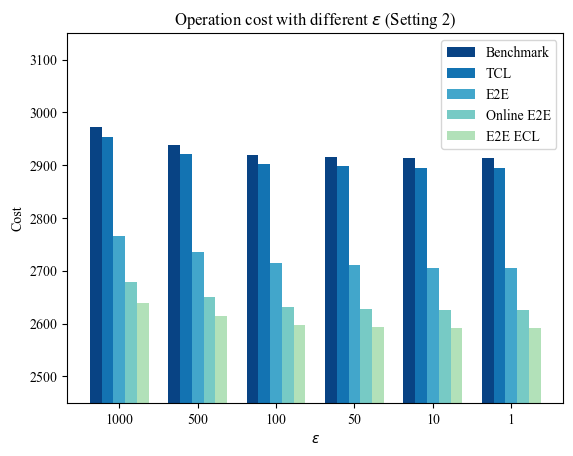

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

cost_1=Cost_with_epsion_org
cost_2=Cost_with_epsion
cost_3=Cost_with_epsion_e2e
cost_4=Cost_with_epsion_online_e2e 
cost_5=Cost_with_epsion_e2e_ecl

color_1 = (8/255, 67/255, 132/255)
color_2 = (19/255, 115/255, 178/255)
color_3 = (66/255, 166/255, 203/255)
color_4 = (119/255, 202/255, 197/255)
color_5 = (178/255, 225/255, 185/255)
# for epsion in [1000,100,10,1,1e-1,1e-2]:
#     print('epsion:',epsion)
#     cost_3.append(np.mean(vars()['cost_list_e2e'+str(epsion)]))
#     cost_1.append(np.mean(vars()['cost_org'+str(epsion)]))
#     cost_2.append(np.mean(vars()['cost_list'+str(epsion)]))
cost_2=np.array(cost_2)
cost_1=np.array(cost_1)
cost_3=np.array(cost_3)
cost_4=np.array(cost_4)
cost_5=np.array(cost_5)
epsions = [1000,500,100,50,10,1]
fig, ax1 = plt.subplots()

bar_width = 0.15
indices = np.arange(len(epsions))

ax1.set_xlabel('epsion')
ax1.set_ylabel('Cost')



ax1.bar(indices -2* bar_width, cost_1, bar_width, label='Benchmark', color=color_1)
#ax1.plot(indices -2* bar_width, cost_1, '-', color=color_1)

ax1.bar(indices- 1* bar_width, cost_2, bar_width, label='TCL', color=color_2)
#ax1.plot(indices- 1 * bar_width, cost_2, '-',  color=color_2)
ax1.bar(indices, cost_3, bar_width, label='E2E', color=color_3)
#ax1.plot(indices, cost_3, '-', color=color_3)

ax1.bar(indices + bar_width, cost_4, bar_width, label='Online E2E', color=color_4)
#ax1.plot(indices + bar_width, cost_4, '-', color=color_4)
ax1.bar(indices + 2 * bar_width, cost_5, bar_width, label='E2E ECL', color=color_5)
#ax1.plot(indices + 2 * bar_width, cost_5, '-', color=color_5)


ax1.legend(loc='upper left')


ax1.set_ylim(2450, 3150)
ax1.set_xlabel(r'$\epsilon$')
ax1.set_xticks(indices)
ax1.set_xticklabels(epsions)

ax1.legend(loc='upper right')
plt.title(r'Operation cost with different $\epsilon$ '+'(Setting '+str(args_train.flag_dynamic_mode)+')')
plt.savefig('../Figure/Cost vs Epsion non parameter'+str(int(args_train.flag_dynamic_price))+str(args_train.flag_dynamic_mode)+'.png')

dic={'Benchmark':cost_1,'TCL':cost_2,'E2E':cost_3,'Online E2E':cost_4,'E2E ECL':cost_5}
df=pd.DataFrame(dic)
df.to_csv('../Result/Cost vs Epsion non parameter'+str(int(args_train.flag_dynamic_price))+str(args_train.flag_dynamic_mode)+'.csv')
plt.show()